Created by Duy Anh Pham
## No installation requires. All the blocks of code are implements on Google Colab (colab.research.google.com)
The reasons of using Google Colab are (1) it is free of charge, (2) it does not require you to install any further libraries to your systems (which is really troublesome sometimes) and (3) it provides 12 consecutive hours of free GPU.

### Instructions:
1. Go to colab.research.google.com (sign in with your gmail account)
2. Upload this notebook to your working repository by clicking File - Upload notebook
3. Change runtime: in order to use free GPU on google colab, please go to Runtime - Change runtime type - set Hardware accelerator to GPU
4. Go through the following sections step by step to achieve the results in the paper.

## With VMD

### Setup environment, import libraries

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
import random
import shutil
from google.colab import files
from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split

#Set a fixed random value so that every time the code is running it will yield the same results.
from numpy.random import seed
seed(1611)

#Set a fixed random value so that every time the code is running it will yield the same results.
tf.random.set_seed(3116)

!git clone https://github.com/a11to1n3/StatFilterAppliedInSTLFDeeplearning.git


# Change to the repository folder
%cd StatFilterAppliedInSTLFDeeplearning

# Import all the neccessary modules in the cloned repository
import dataWrangling
import dataPCA
import dataHourSplit
import dataFilter
import confidenceLevelFitness
import LSTMModelBuilder
import CNNLSTMModelBuilder
import wavenet
import RBMDAE
import waveletFunction
import modelBuilder

!pip install vmdpy
from vmdpy import VMD

Cloning into 'StatFilterAppliedInSTLFDeeplearning'...
remote: Enumerating objects: 183, done.
remote: Counting objects: 100% (183/183), done.
remote: Compressing objects: 100% (128/128), done.
remote: Total 183 (delta 110), reused 128 (delta 55), pack-reused 0
Receiving objects: 100% (183/183), 3.89 MiB | 3.43 MiB/s, done.
Resolving deltas: 100% (110/110), done.
/content/StatFilterAppliedInSTLFDeeplearning


### Load dataset

In [ ]:
# Run this and select the DayMarked.csv file in your computer
files.upload()

### Pre-process dataset to 133 dimensions and scale it

The shape of the array is: (1818, 24, 133)


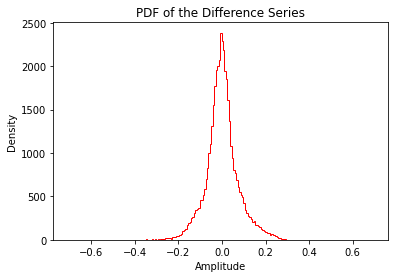

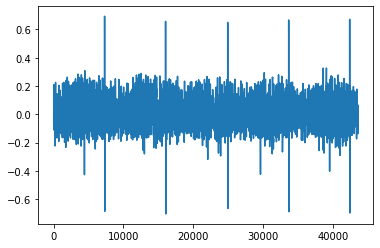

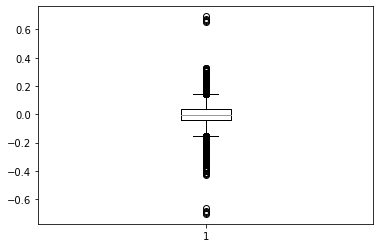

In [9]:
wrangledData = dataWrangling.csvToArray('DayMarkedNYISOO.csv')
#wrangledData = dataWrangling.csvToArray('DayMarked (STLF Data Inputs Template) 13112019.csv')

# Check for the shape of the array after wrangling the data
print("The shape of the array is: {}".format(np.shape(wrangledData)))

data_scaled, data_orig = dataPCA.diffandScaleISONE(wrangledData)

### Search confidence level

In [34]:
# Data filtered with confidence level of 90
data_90 = dataFilter.filterWithConfidenceLevel(data_scaled, 90)

# Data filtered with confidence level of 91
data_91 = dataFilter.filterWithConfidenceLevel(data_scaled, 91)

# Data filtered with confidence level of 92
data_92 = dataFilter.filterWithConfidenceLevel(data_scaled, 92)

# Data filtered with confidence level of 93
data_93 = dataFilter.filterWithConfidenceLevel(data_scaled, 93)

# Data filtered with confidence level of 94
data_94 = dataFilter.filterWithConfidenceLevel(data_scaled, 94)

# Data filtered with confidence level of 95
data_95 = dataFilter.filterWithConfidenceLevel(data_scaled, 95)

# Data filtered with confidence level of 96
data_96 = dataFilter.filterWithConfidenceLevel(data_scaled, 96)

# Data filtered with confidence level of 97
data_97 = dataFilter.filterWithConfidenceLevel(data_scaled, 97)

# Data filtered with confidence level of 98
data_98 = dataFilter.filterWithConfidenceLevel(data_scaled, 98)

# Data filtered with confidence level of 99
data_99 = dataFilter.filterWithConfidenceLevel(data_scaled, 99)

# Data filtered with confidence level of 99.73
data_3sigma = dataFilter.filterWithConfidenceLevel(data_scaled, 99.73)

# Data filtered with confidence level of 99.99366
data_4sigma = dataFilter.filterWithConfidenceLevel(data_scaled, 99.99366)

# Data filtered with confidence level of 99.99932
data_4sigma5 = dataFilter.filterWithConfidenceLevel(data_scaled, 99.99932)

### Data preparation for the main forecasting algorithm

#### With filter

##### Do VMD

- VMD in this implementation is taken from the `vmdpy` library, built by the authors of the VMD methods
- VMD, by definitions, takes six parameters, which are:
  - `alpha`: is defined as the moderate bandwidth constraint, empirically this has to be set to double the maximum samples in the training dataset
  - `tau`: is defined as the noise tolerance factor, which is used to assure the faithfulness to the original time series of the decomposed series
  - `K`: number of decomposition
  - `DC`: involve/ not involve the DC component
  - `init`: consists of three modes for initiating the omega factor: 0 - initiating with zero values; 1 - all omegas are uniformly distributed; 2 - all omegas are initiated randomly
  - `tol`: tolerance of convergence criterion, typically 1e-6
- This implementation of VMD requires a combination of correct settings of its parameters. For `alpha`, it is clear to set it to twice the training dataset samples, because it relates to the formulation $2*T_S$. `tau` is set to 0, as we would not want to tightly involve the noise into the decomposition as it will get very fit to the series, which can induce more noisy results. `K` is set to 5, as of the experiments, 5 is the turning point between good and bad results when inputing to our forecasting model. We would not want a `DC` component in the decompositions as it affects their smoothness. We set `init` to 1, as we want to initiate the omegas with uniformly distributed. 



In [38]:
#. some sample parameters for VMD  
alpha = 2*len(data_95[:-int(0.1*len(data_95)),:,0].reshape(-1))      # moderate bandwidth constraint  
tau = 0.            # noise-tolerance (no strict fidelity enforcement)  
K = 5           # 5 modes  
DC = False             # no DC part imposed  
init = 1           # initialize omegas uniformly  
tol = 1e-6  

u, u_hat, omega = VMD(data_95[:-int(0.1*len(data_95)),:,0].reshape(-1), alpha, tau, K, DC, init, tol)

Component 1


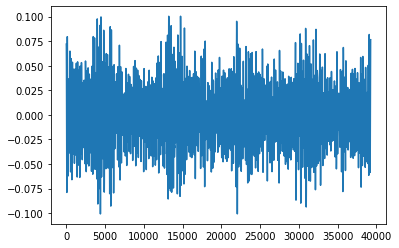

Component 2


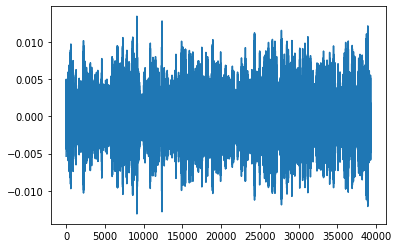

Component 3


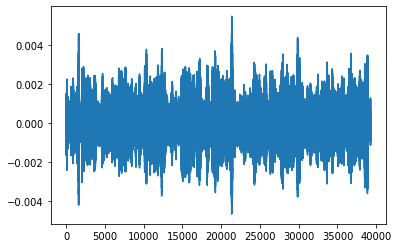

Component 4


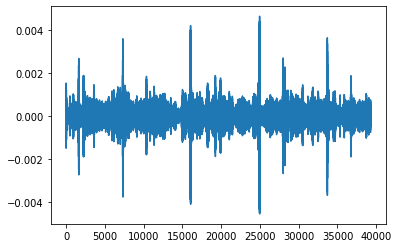

Component 5


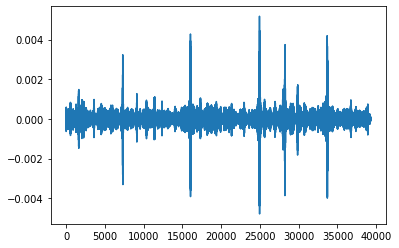

In [39]:
print("Component 1")
plt.plot(u.T[:,0])
plt.show()

print("Component 2")
plt.plot(u.T[:,1])
plt.show()

print("Component 3")
plt.plot(u.T[:,2])
plt.show()

print("Component 4")
plt.plot(u.T[:,3])
plt.show()

print("Component 5")
plt.plot(u.T[:,4])
plt.show()

In [40]:
import copy

# split to 5 subsets
data_scaled1 = np.zeros_like(data_scaled[:-int(0.1*len(data_scaled))])
data_scaled1[:,:,1:] = copy.deepcopy(data_scaled[:-int(0.1*len(data_scaled)),:,1:])
data_scaled2 = np.zeros_like(data_scaled[:-int(0.1*len(data_scaled))])
data_scaled2[:,:,1:] = copy.deepcopy(data_scaled[:-int(0.1*len(data_scaled)),:,1:])
data_scaled3 = np.zeros_like(data_scaled[:-int(0.1*len(data_scaled))])
data_scaled3[:,:,1:] = copy.deepcopy(data_scaled[:-int(0.1*len(data_scaled)),:,1:])
data_scaled4 = np.zeros_like(data_scaled[:-int(0.1*len(data_scaled))])
data_scaled4[:,:,1:] = copy.deepcopy(data_scaled[:-int(0.1*len(data_scaled)),:,1:])
data_scaled5 = np.zeros_like(data_scaled[:-int(0.1*len(data_scaled))])
data_scaled5[:,:,1:] = copy.deepcopy(data_scaled[:-int(0.1*len(data_scaled)),:,1:])


data_scaled1[:,:,0] = u[0,:].reshape(-1,24)
data_scaled2[:,:,0] = u[1,:].reshape(-1,24)
data_scaled3[:,:,0] = u[2,:].reshape(-1,24)
data_scaled4[:,:,0] = u[3,:].reshape(-1,24)
data_scaled5[:,:,0] = u[4,:].reshape(-1,24)

print(data_scaled1.shape)

(1636, 24, 133)


#### No filter

##### Do VMD

- VMD in this implementation is taken from the `vmdpy` library, built by the authors of the VMD methods
- VMD, by definitions, takes six parameters, which are:
  - `alpha`: is defined as the moderate bandwidth constraint, empirically this has to be set to double the maximum samples in the training dataset
  - `tau`: is defined as the noise tolerance factor, which is used to assure the faithfulness to the original time series of the decomposed series
  - `K`: number of decomposition
  - `DC`: involve/ not involve the DC component
  - `init`: consists of three modes for initiating the omega factor: 0 - initiating with zero values; 1 - all omegas are uniformly distributed; 2 - all omegas are initiated randomly
  - `tol`: tolerance of convergence criterion, typically 1e-6
- This implementation of VMD requires a combination of correct settings of its parameters. For `alpha`, it is clear to set it to twice the training dataset samples, because it relates to the formulation $2*T_S$. `tau` is set to 0, as we would not want to tightly involve the noise into the decomposition as it will get very fit to the series, which can induce more noisy results. `K` is set to 5, as of the experiments, 5 is the turning point between good and bad results when inputing to our forecasting model. We would not want a `DC` component in the decompositions as it affects their smoothness. We set `init` to 1, as we want to initiate the omegas with uniformly distributed. 



In [59]:
#. some sample parameters for VMD  
alpha = 2*len(data_scaled[:-int(0.1*len(data_scaled)),:,0].reshape(-1))      # moderate bandwidth constraint  
tau = 0.            # noise-tolerance (no strict fidelity enforcement)  
K = 5           # 5 modes  
DC = False             # no DC part imposed  
init = 1           # initialize omegas uniformly  
tol = 1e-6  

u, u_hat, omega = VMD(data_scaled[:-int(0.1*len(data_scaled)),:,0].reshape(-1), alpha, tau, K, DC, init, tol)

Component 1


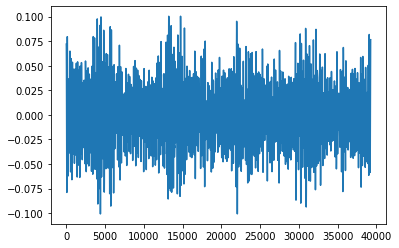

Component 2


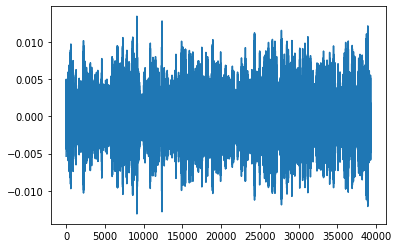

Component 3


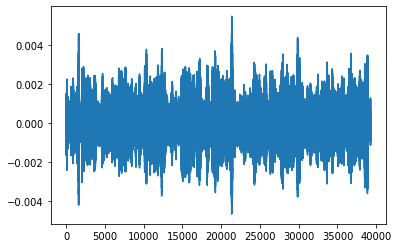

Component 4


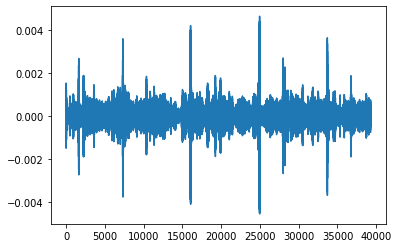

Component 5


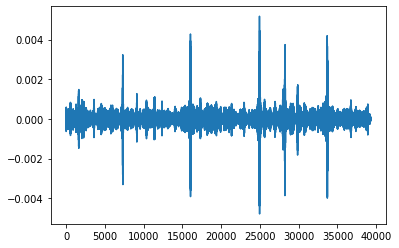

In [60]:
print("Component 1")
plt.plot(u.T[:,0])
plt.show()

print("Component 2")
plt.plot(u.T[:,1])
plt.show()

print("Component 3")
plt.plot(u.T[:,2])
plt.show()

print("Component 4")
plt.plot(u.T[:,3])
plt.show()

print("Component 5")
plt.plot(u.T[:,4])
plt.show()

In [61]:
import copy

# split to 5 subsets
data_scaled1 = np.zeros_like(data_scaled[:-int(0.1*len(data_scaled))])
data_scaled1[:,:,1:] = copy.deepcopy(data_scaled[:-int(0.1*len(data_scaled)),:,1:])
data_scaled2 = np.zeros_like(data_scaled[:-int(0.1*len(data_scaled))])
data_scaled2[:,:,1:] = copy.deepcopy(data_scaled[:-int(0.1*len(data_scaled)),:,1:])
data_scaled3 = np.zeros_like(data_scaled[:-int(0.1*len(data_scaled))])
data_scaled3[:,:,1:] = copy.deepcopy(data_scaled[:-int(0.1*len(data_scaled)),:,1:])
data_scaled4 = np.zeros_like(data_scaled[:-int(0.1*len(data_scaled))])
data_scaled4[:,:,1:] = copy.deepcopy(data_scaled[:-int(0.1*len(data_scaled)),:,1:])
data_scaled5 = np.zeros_like(data_scaled[:-int(0.1*len(data_scaled))])
data_scaled5[:,:,1:] = copy.deepcopy(data_scaled[:-int(0.1*len(data_scaled)),:,1:])


data_scaled1[:,:,0] = u[0,:].reshape(-1,24)
data_scaled2[:,:,0] = u[1,:].reshape(-1,24)
data_scaled3[:,:,0] = u[2,:].reshape(-1,24)
data_scaled4[:,:,0] = u[3,:].reshape(-1,24)
data_scaled5[:,:,0] = u[4,:].reshape(-1,24)

print(data_scaled1.shape)

(1636, 24, 133)


### Model preparation

#### LSTM 

In [62]:
inp1 = data_scaled1[:-int(0.1*len(data_scaled1))-1]
out1 = data_scaled1[1:-int(0.1*len(data_scaled1))]

inp2 = data_scaled2[:-int(0.1*len(data_scaled2))-1]
out2 = data_scaled2[1:-int(0.1*len(data_scaled2))]

inp3 = data_scaled3[:-int(0.1*len(data_scaled3))-1]
out3 = data_scaled3[1:-int(0.1*len(data_scaled3))]

inp4 = data_scaled4[:-int(0.1*len(data_scaled4))-1]
out4 = data_scaled4[1:-int(0.1*len(data_scaled4))]

inp5 = data_scaled5[:-int(0.1*len(data_scaled5))-1]
out5 = data_scaled5[1:-int(0.1*len(data_scaled5))]

In [63]:
# for pure keras
x_train1, x_val1, y_train1, y_val1 = train_test_split(inp1,out1,
                                                  random_state=42, test_size =0.33,shuffle=False)

BATCH_SIZE = 4
BUFFER_SIZE = 1000

train1 = tf.data.Dataset.from_tensor_slices((x_train1, y_train1[:,:,0]))
#train = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat().prefetch(1)
train1 = train1.cache().batch(BATCH_SIZE).repeat()


val1 = tf.data.Dataset.from_tensor_slices((x_val1, y_val1[:,:,0]))
val1 = val1.batch(BATCH_SIZE).repeat().prefetch(1)

In [64]:
model1 = LSTMModelBuilder.build(data_scaled1.shape[1],data_scaled1.shape[2])
model1.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 24, 20)            12320     
_________________________________________________________________
lstm_11 (LSTM)               (None, 20)                3280      
_________________________________________________________________
dropout_5 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 24)                504       
Total params: 16,104
Trainable params: 16,104
Non-trainable params: 0
_________________________________________________________________


In [65]:
# for pure keras
x_train2, x_val2, y_train2, y_val2 = train_test_split(inp2,out2,
                                                  random_state=42, test_size =0.33,shuffle=False)

BATCH_SIZE = 4
BUFFER_SIZE = 1000

train2 = tf.data.Dataset.from_tensor_slices((x_train2, y_train2[:,:,0]))
#train = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat().prefetch(1)
train2 = train2.cache().batch(BATCH_SIZE).repeat()


val2 = tf.data.Dataset.from_tensor_slices((x_val2, y_val2[:,:,0]))
val2 = val2.batch(BATCH_SIZE).repeat().prefetch(1)

In [66]:
model2 = LSTMModelBuilder.build(data_scaled2.shape[1],data_scaled2.shape[2])
model2.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 24, 20)            12320     
_________________________________________________________________
lstm_13 (LSTM)               (None, 20)                3280      
_________________________________________________________________
dropout_6 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 24)                504       
Total params: 16,104
Trainable params: 16,104
Non-trainable params: 0
_________________________________________________________________


In [67]:
# for pure keras
x_train3, x_val3, y_train3, y_val3 = train_test_split(inp3,out3,
                                                  random_state=42, test_size =0.33,shuffle=False)

BATCH_SIZE = 4
BUFFER_SIZE = 1000

train3 = tf.data.Dataset.from_tensor_slices((x_train3, y_train3[:,:,0]))
#train = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat().prefetch(1)
train3 = train3.cache().batch(BATCH_SIZE).repeat()


val3 = tf.data.Dataset.from_tensor_slices((x_val3, y_val3[:,:,0]))
val3 = val3.batch(BATCH_SIZE).repeat().prefetch(1)

In [68]:
model3 = LSTMModelBuilder.build(data_scaled3.shape[1],data_scaled3.shape[2])
model3.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 24, 20)            12320     
_________________________________________________________________
lstm_15 (LSTM)               (None, 20)                3280      
_________________________________________________________________
dropout_7 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 24)                504       
Total params: 16,104
Trainable params: 16,104
Non-trainable params: 0
_________________________________________________________________


In [69]:
# for pure keras
x_train4, x_val4, y_train4, y_val4 = train_test_split(inp4,out4,
                                                  random_state=42, test_size =0.33,shuffle=False)

BATCH_SIZE = 4
BUFFER_SIZE = 1000

train4 = tf.data.Dataset.from_tensor_slices((x_train4, y_train4[:,:,0]))
#train = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat().prefetch(1)
train4 = train4.cache().batch(BATCH_SIZE).repeat()


val4 = tf.data.Dataset.from_tensor_slices((x_val4, y_val4[:,:,0]))
val4 = val4.batch(BATCH_SIZE).repeat().prefetch(1)

In [70]:
model4 = LSTMModelBuilder.build(data_scaled4.shape[1],data_scaled4.shape[2])
model4.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 24, 20)            12320     
_________________________________________________________________
lstm_17 (LSTM)               (None, 20)                3280      
_________________________________________________________________
dropout_8 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 24)                504       
Total params: 16,104
Trainable params: 16,104
Non-trainable params: 0
_________________________________________________________________


In [71]:
# for pure keras
x_train5, x_val5, y_train5, y_val5 = train_test_split(inp5,out5,
                                                  random_state=42, test_size =0.33,shuffle=False)

BATCH_SIZE = 4
BUFFER_SIZE = 1000

train5 = tf.data.Dataset.from_tensor_slices((x_train5, y_train5[:,:,0]))
#train = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat().prefetch(1)
train5 = train5.cache().batch(BATCH_SIZE).repeat()


val5 = tf.data.Dataset.from_tensor_slices((x_val5, y_val5[:,:,0]))
val5 = val5.batch(BATCH_SIZE).repeat().prefetch(1)

In [72]:
model5 = LSTMModelBuilder.build(data_scaled5.shape[1],data_scaled5.shape[2])
model5.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 24, 20)            12320     
_________________________________________________________________
lstm_19 (LSTM)               (None, 20)                3280      
_________________________________________________________________
dropout_9 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 24)                504       
Total params: 16,104
Trainable params: 16,104
Non-trainable params: 0
_________________________________________________________________


##### Training

###### With filter

In [53]:
#for tensorflow 2.0
import datetime
# plot_val1 = []
# class MyCustomCallback(tf.keras.callbacks.Callback):
#   def on_epoch_end(self, epoch, logs=None):
#     print('Evaluating: epoch {} ends at {} with MAPE '.format(epoch, datetime.datetime.now().time()))
#     checkpoint_path = './'+str(datetime.datetime.now().time())+"_cp.h5" 
#     #checkpoint_dir = os.path.dirname(checkpoint_path)
#     model1.save(checkpoint_path)
#     AVG = []
#     AVG1 = []
#     AVG2 = []
#     pred = []
    
#     for i in range(len(test_inp1)):
#       test_pred = model1.predict(test_inp1[i].reshape(-1,data_scaled1.shape[1],133))
#       pred.append(test_pred)
#       real_pred = data_scaler1.inverse_transform(test_pred)
#       # real_pred = np.log(pretest_inp[i,:,0].T) + test_pred
#       # real_pred = np.e**real_pred
#       #print(test_pred.shape)
#       #print(real_pred)
#       #print(pretest_out[i,:,0])
#       #print(abs((real_pred.T.reshape(-1)-pretest_out[i,:,0].reshape(-1)))/pretest_out[i,:,0].reshape(-1))
#       plot_val1.append([real_pred.T.reshape(-1),pretest_out1[i,:,0].reshape(-1)])
#       #AVG.append(np.sum(abs((real_pred.T.reshape(-1)-test_scaler.inverse_transform(pretest_out[i,:,0:1].T).reshape(-1)))/test_scaler.inverse_transform(pretest_out[i,:,0:1].T).reshape(-1))*100/24)
#       #AVG1.append(np.sum(abs((real_pred.T.reshape(-1)-test_scaler.inverse_transform(pretest_out[i,:,0:1].T).reshape(-1))))/24)
#       #AVG2.append((np.sum(abs((real_pred.T.reshape(-1)-test_scaler.inverse_transform(pretest_out[i,:,0:1].T).reshape(-1))))/24)**2)
#       AVG.append(np.sum(abs((real_pred.T.reshape(-1)-pretest_out1[i,:,0].reshape(-1)))/pretest_out1[i,:,0].reshape(-1))*100/24)
#       AVG1.append(np.sum(abs((real_pred.T.reshape(-1)-pretest_out1[i,:,0].reshape(-1))))/24)
#       AVG2.append((np.sum(abs((real_pred.T.reshape(-1)-pretest_out1[i,:,0].reshape(-1))))/24)**2)
#     AVG = np.array(AVG)
#     AVG1 = np.array(AVG1)
#     AVG2 = np.array(AVG2)
#     pred=np.array(pred)
#     print(np.sum(AVG)/len(test_inp1))
#     print(np.sum(AVG1)/len(test_inp1))
#     print((np.sqrt(np.sum(AVG2)/len(test_inp1))))

def scheduler(epoch):
  if epoch < 5:
    return 0.01
  else:
    return 0.001 * np.math.exp(0.1 * (1 - epoch))

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
#callback2 = tf.keras.callbacks.EarlyStopping(mode="min", monitor='val_loss')
model1.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae',metrics=['mse','mape'])


# fit network
history = model1.fit(train1, steps_per_epoch=x_train1.shape[0]//BATCH_SIZE, epochs=30,
                      validation_data=val1, validation_steps=x_val1.shape[0]//BATCH_SIZE,callbacks=[tensorboard_callback, callback])

Epoch 1/30
  1/246 [..............................] - ETA: 0s - loss: 0.1819 - mse: 0.0528 - mape: 1100.4717WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
246/246 [==============================] - 5s 20ms/step - loss: 0.0341 - mse: 0.0030 - mape: 565.5807 - val_loss: 0.0205 - val_mse: 6.8657e-04 - val_mape: 284.6267
Epoch 2/30
246/246 [==============================] - 5s 21ms/step - loss: 0.0223 - mse: 8.1819e-04 - mape: 409.9139 - val_loss: 0.0236 - val_mse: 8.6606e-04 - val_mape: 383.2408
Epoch 3/30
246/246 [==============================] - 4s 18ms/step - loss: 0.0207 - mse: 7.1478e-04 - mape: 384.1935 - val_loss: 0.0271 - val_mse: 0.0012 - val_mape: 513.1205
Epoch 4/30
246/246 [==============================] - 5s 18ms/step - loss: 0.0194 - mse: 6.3898e

In [54]:
#for tensorflow 2.0
import datetime
# plot_val2 = []
# class MyCustomCallback(tf.keras.callbacks.Callback):
#   def on_epoch_end(self, epoch, logs=None):
#     print('Evaluating: epoch {} ends at {} with MAPE '.format(epoch, datetime.datetime.now().time()))
#     checkpoint_path = './'+str(datetime.datetime.now().time())+"_cp.h5" 
#     #checkpoint_dir = os.path.dirname(checkpoint_path)
#     model2.save(checkpoint_path)
#     AVG = []
#     AVG1 = []
#     AVG2 = []
#     pred = []
    
#     for i in range(len(test_inp2)):
#       test_pred = model2.predict(test_inp2[i].reshape(-1,data_scaled2.shape[1],133))
#       pred.append(test_pred)
#       real_pred = data_scaler2.inverse_transform(test_pred)
#       # real_pred = np.log(pretest_inp[i,:,0].T) + test_pred
#       # real_pred = np.e**real_pred
#       #print(test_pred.shape)
#       #print(real_pred)
#       #print(pretest_out[i,:,0])
#       #print(abs((real_pred.T.reshape(-1)-pretest_out[i,:,0].reshape(-1)))/pretest_out[i,:,0].reshape(-1))
#       plot_val2.append([real_pred.T.reshape(-1),pretest_out2[i,:,0].reshape(-1)])
#       #AVG.append(np.sum(abs((real_pred.T.reshape(-1)-test_scaler.inverse_transform(pretest_out[i,:,0:1].T).reshape(-1)))/test_scaler.inverse_transform(pretest_out[i,:,0:1].T).reshape(-1))*100/24)
#       #AVG1.append(np.sum(abs((real_pred.T.reshape(-1)-test_scaler.inverse_transform(pretest_out[i,:,0:1].T).reshape(-1))))/24)
#       #AVG2.append((np.sum(abs((real_pred.T.reshape(-1)-test_scaler.inverse_transform(pretest_out[i,:,0:1].T).reshape(-1))))/24)**2)
#       AVG.append(np.sum(abs((real_pred.T.reshape(-1)-pretest_out2[i,:,0].reshape(-1)))/pretest_out2[i,:,0].reshape(-1))*100/24)
#       AVG1.append(np.sum(abs((real_pred.T.reshape(-1)-pretest_out2[i,:,0].reshape(-1))))/24)
#       AVG2.append((np.sum(abs((real_pred.T.reshape(-1)-pretest_out2[i,:,0].reshape(-1))))/24)**2)
#     AVG = np.array(AVG)
#     AVG1 = np.array(AVG1)
#     AVG2 = np.array(AVG2)
#     pred=np.array(pred)
#     print(np.sum(AVG)/len(test_inp2))
#     print(np.sum(AVG1)/len(test_inp2))
#     print((np.sqrt(np.sum(AVG2)/len(test_inp2))))

def scheduler(epoch):
  if epoch < 5:
    return 0.01
  else:
    return 0.001 * np.math.exp(0.1 * (1 - epoch))

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
#callback2 = tf.keras.callbacks.EarlyStopping(mode="min", monitor='val_loss')
model2.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae',metrics=['mse','mape'])


# fit network
history = model2.fit(train2, steps_per_epoch=x_train2.shape[0]//BATCH_SIZE, epochs=30,
                      validation_data=val2, validation_steps=x_val2.shape[0]//BATCH_SIZE,callbacks=[tensorboard_callback, callback])

Epoch 1/30
246/246 [==============================] - 5s 21ms/step - loss: 0.0148 - mse: 0.0019 - mape: 3667.5723 - val_loss: 0.0051 - val_mse: 3.8776e-05 - val_mape: 1249.4664
Epoch 2/30
246/246 [==============================] - 4s 18ms/step - loss: 0.0052 - mse: 3.9608e-05 - mape: 1486.6285 - val_loss: 0.0054 - val_mse: 4.1572e-05 - val_mape: 986.6572
Epoch 3/30
246/246 [==============================] - 4s 18ms/step - loss: 0.0052 - mse: 3.8194e-05 - mape: 1268.5775 - val_loss: 0.0044 - val_mse: 2.8798e-05 - val_mape: 1245.7343
Epoch 4/30
246/246 [==============================] - 4s 18ms/step - loss: 0.0051 - mse: 3.7628e-05 - mape: 1327.1025 - val_loss: 0.0053 - val_mse: 3.9851e-05 - val_mape: 1199.8121
Epoch 5/30
246/246 [==============================] - 5s 19ms/step - loss: 0.0051 - mse: 3.7728e-05 - mape: 1236.6565 - val_loss: 0.0056 - val_mse: 4.3230e-05 - val_mape: 1756.9924
Epoch 6/30
246/246 [==============================] - 5s 19ms/step - loss: 0.0020 - mse: 6.9684e-06 

In [55]:
#for tensorflow 2.0
import datetime
# plot_val3 = []
# class MyCustomCallback(tf.keras.callbacks.Callback):
#   def on_epoch_end(self, epoch, logs=None):
#     print('Evaluating: epoch {} ends at {} with MAPE '.format(epoch, datetime.datetime.now().time()))
#     checkpoint_path = './'+str(datetime.datetime.now().time())+"_cp.h5" 
#     #checkpoint_dir = os.path.dirname(checkpoint_path)
#     model3.save(checkpoint_path)
#     AVG = []
#     AVG1 = []
#     AVG2 = []
#     pred = []
    
#     for i in range(len(test_inp3)):
#       test_pred = model3.predict(test_inp3[i].reshape(-1,data_scaled3.shape[1],133))
#       pred.append(test_pred)
#       real_pred = data_scaler3.inverse_transform(test_pred)
#       # real_pred = np.log(pretest_inp[i,:,0].T) + test_pred
#       # real_pred = np.e**real_pred
#       #print(test_pred.shape)
#       #print(real_pred)
#       #print(pretest_out[i,:,0])
#       #print(abs((real_pred.T.reshape(-1)-pretest_out[i,:,0].reshape(-1)))/pretest_out[i,:,0].reshape(-1))
#       plot_val3.append([real_pred.T.reshape(-1),pretest_out3[i,:,0].reshape(-1)])
#       #AVG.append(np.sum(abs((real_pred.T.reshape(-1)-test_scaler.inverse_transform(pretest_out[i,:,0:1].T).reshape(-1)))/test_scaler.inverse_transform(pretest_out[i,:,0:1].T).reshape(-1))*100/24)
#       #AVG1.append(np.sum(abs((real_pred.T.reshape(-1)-test_scaler.inverse_transform(pretest_out[i,:,0:1].T).reshape(-1))))/24)
#       #AVG2.append((np.sum(abs((real_pred.T.reshape(-1)-test_scaler.inverse_transform(pretest_out[i,:,0:1].T).reshape(-1))))/24)**2)
#       AVG.append(np.sum(abs((real_pred.T.reshape(-1)-pretest_out3[i,:,0].reshape(-1)))/pretest_out3[i,:,0].reshape(-1))*100/24)
#       AVG1.append(np.sum(abs((real_pred.T.reshape(-1)-pretest_out3[i,:,0].reshape(-1))))/24)
#       AVG2.append((np.sum(abs((real_pred.T.reshape(-1)-pretest_out3[i,:,0].reshape(-1))))/24)**2)
#     AVG = np.array(AVG)
#     AVG1 = np.array(AVG1)
#     AVG2 = np.array(AVG2)
#     pred=np.array(pred)
#     print(np.sum(AVG)/len(test_inp3))
#     print(np.sum(AVG1)/len(test_inp3))
#     print((np.sqrt(np.sum(AVG2)/len(test_inp3))))

def scheduler(epoch):
  if epoch < 5:
    return 0.01
  else:
    return 0.001 * np.math.exp(0.1 * (1 - epoch))

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
#callback2 = tf.keras.callbacks.EarlyStopping(mode="min", monitor='val_loss')
model3.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae',metrics=['mse','mape'])


# fit network
history = model3.fit(train3, steps_per_epoch=x_train3.shape[0]//BATCH_SIZE, epochs=30,
                      validation_data=val3, validation_steps=x_val3.shape[0]//BATCH_SIZE,callbacks=[tensorboard_callback, callback])

Epoch 1/30
246/246 [==============================] - 5s 22ms/step - loss: 0.0150 - mse: 0.0018 - mape: 13599.6689 - val_loss: 0.0060 - val_mse: 4.1661e-05 - val_mape: 3637.2280
Epoch 2/30
246/246 [==============================] - 4s 18ms/step - loss: 0.0051 - mse: 3.2035e-05 - mape: 3650.7136 - val_loss: 0.0037 - val_mse: 1.8194e-05 - val_mape: 2947.2290
Epoch 3/30
246/246 [==============================] - 4s 18ms/step - loss: 0.0050 - mse: 2.9792e-05 - mape: 3918.0779 - val_loss: 0.0058 - val_mse: 3.8591e-05 - val_mape: 3942.0955
Epoch 4/30
246/246 [==============================] - 4s 17ms/step - loss: 0.0050 - mse: 2.9830e-05 - mape: 3951.7004 - val_loss: 0.0047 - val_mse: 2.7668e-05 - val_mape: 3520.8955
Epoch 5/30
246/246 [==============================] - 4s 17ms/step - loss: 0.0050 - mse: 2.9837e-05 - mape: 3951.8552 - val_loss: 0.0053 - val_mse: 3.4223e-05 - val_mape: 3697.6758
Epoch 6/30
246/246 [==============================] - 4s 18ms/step - loss: 0.0011 - mse: 2.2227e-0

In [56]:
#for tensorflow 2.0
import datetime
# plot_val4 = []
# class MyCustomCallback(tf.keras.callbacks.Callback):
#   def on_epoch_end(self, epoch, logs=None):
#     print('Evaluating: epoch {} ends at {} with MAPE '.format(epoch, datetime.datetime.now().time()))
#     checkpoint_path = './'+str(datetime.datetime.now().time())+"_cp.h5" 
#     #checkpoint_dir = os.path.dirname(checkpoint_path)
#     model4.save(checkpoint_path)
#     AVG = []
#     AVG1 = []
#     AVG2 = []
#     pred = []
    
#     for i in range(len(test_inp4)):
#       test_pred = model4.predict(test_inp4[i].reshape(-1,data_scaled4.shape[1],133))
#       pred.append(test_pred)
#       real_pred = data_scaler4.inverse_transform(test_pred)
#       # real_pred = np.log(pretest_inp[i,:,0].T) + test_pred
#       # real_pred = np.e**real_pred
#       #print(test_pred.shape)
#       #print(real_pred)
#       #print(pretest_out[i,:,0])
#       #print(abs((real_pred.T.reshape(-1)-pretest_out[i,:,0].reshape(-1)))/pretest_out[i,:,0].reshape(-1))
#       plot_val4.append([real_pred.T.reshape(-1),pretest_out4[i,:,0].reshape(-1)])
#       #AVG.append(np.sum(abs((real_pred.T.reshape(-1)-test_scaler.inverse_transform(pretest_out[i,:,0:1].T).reshape(-1)))/test_scaler.inverse_transform(pretest_out[i,:,0:1].T).reshape(-1))*100/24)
#       #AVG1.append(np.sum(abs((real_pred.T.reshape(-1)-test_scaler.inverse_transform(pretest_out[i,:,0:1].T).reshape(-1))))/24)
#       #AVG2.append((np.sum(abs((real_pred.T.reshape(-1)-test_scaler.inverse_transform(pretest_out[i,:,0:1].T).reshape(-1))))/24)**2)
#       AVG.append(np.sum(abs((real_pred.T.reshape(-1)-pretest_out4[i,:,0].reshape(-1)))/pretest_out4[i,:,0].reshape(-1))*100/24)
#       AVG1.append(np.sum(abs((real_pred.T.reshape(-1)-pretest_out4[i,:,0].reshape(-1))))/24)
#       AVG2.append((np.sum(abs((real_pred.T.reshape(-1)-pretest_out4[i,:,0].reshape(-1))))/24)**2)
#     AVG = np.array(AVG)
#     AVG1 = np.array(AVG1)
#     AVG2 = np.array(AVG2)
#     pred=np.array(pred)
#     print(np.sum(AVG)/len(test_inp4))
#     print(np.sum(AVG1)/len(test_inp4))
#     print((np.sqrt(np.sum(AVG2)/len(test_inp4))))

def scheduler(epoch):
  if epoch < 5:
    return 0.01
  else:
    return 0.001 * np.math.exp(0.1 * (1 - epoch))

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
#callback2 = tf.keras.callbacks.EarlyStopping(mode="min", monitor='val_loss')
model4.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae',metrics=['mse','mape'])


# fit network
history = model4.fit(train4, steps_per_epoch=x_train4.shape[0]//BATCH_SIZE, epochs=30,
                      validation_data=val4, validation_steps=x_val4.shape[0]//BATCH_SIZE,callbacks=[tensorboard_callback, callback])

Epoch 1/30
246/246 [==============================] - 5s 22ms/step - loss: 0.0140 - mse: 0.0017 - mape: 25900.7871 - val_loss: 0.0050 - val_mse: 3.1349e-05 - val_mape: 8270.3555
Epoch 2/30
246/246 [==============================] - 4s 18ms/step - loss: 0.0051 - mse: 3.1353e-05 - mape: 8347.1367 - val_loss: 0.0045 - val_mse: 2.3186e-05 - val_mape: 6666.5596
Epoch 3/30
246/246 [==============================] - 4s 18ms/step - loss: 0.0050 - mse: 2.8145e-05 - mape: 8014.2466 - val_loss: 0.0045 - val_mse: 2.3104e-05 - val_mape: 6821.7139
Epoch 4/30
246/246 [==============================] - 4s 18ms/step - loss: 0.0050 - mse: 2.8374e-05 - mape: 8089.2539 - val_loss: 0.0047 - val_mse: 2.5583e-05 - val_mape: 7114.8184
Epoch 5/30
246/246 [==============================] - 4s 18ms/step - loss: 0.0050 - mse: 2.8641e-05 - mape: 8364.1436 - val_loss: 0.0047 - val_mse: 2.5487e-05 - val_mape: 7203.3760
Epoch 6/30
246/246 [==============================] - 4s 17ms/step - loss: 5.6073e-04 - mse: 7.353

In [57]:
#for tensorflow 2.0
import datetime
# plot_val5 = []
# class MyCustomCallback(tf.keras.callbacks.Callback):
#   def on_epoch_end(self, epoch, logs=None):
#     print('Evaluating: epoch {} ends at {} with MAPE '.format(epoch, datetime.datetime.now().time()))
#     checkpoint_path = './'+str(datetime.datetime.now().time())+"_cp.h5" 
#     #checkpoint_dir = os.path.dirname(checkpoint_path)
#     model5.save(checkpoint_path)
#     AVG = []
#     AVG1 = []
#     AVG2 = []
#     pred = []
    
#     for i in range(len(test_inp5)):
#       test_pred = model5.predict(test_inp5[i].reshape(-1,data_scaled5.shape[1],133))
#       pred.append(test_pred)
#       real_pred = data_scaler5.inverse_transform(test_pred)
#       # real_pred = np.log(pretest_inp[i,:,0].T) + test_pred
#       # real_pred = np.e**real_pred
#       #print(test_pred.shape)
#       #print(real_pred)
#       #print(pretest_out[i,:,0])
#       #print(abs((real_pred.T.reshape(-1)-pretest_out[i,:,0].reshape(-1)))/pretest_out[i,:,0].reshape(-1))
#       plot_val5.append([real_pred.T.reshape(-1),pretest_out5[i,:,0].reshape(-1)])
#       #AVG.append(np.sum(abs((real_pred.T.reshape(-1)-test_scaler.inverse_transform(pretest_out[i,:,0:1].T).reshape(-1)))/test_scaler.inverse_transform(pretest_out[i,:,0:1].T).reshape(-1))*100/24)
#       #AVG1.append(np.sum(abs((real_pred.T.reshape(-1)-test_scaler.inverse_transform(pretest_out[i,:,0:1].T).reshape(-1))))/24)
#       #AVG2.append((np.sum(abs((real_pred.T.reshape(-1)-test_scaler.inverse_transform(pretest_out[i,:,0:1].T).reshape(-1))))/24)**2)
#       AVG.append(np.sum(abs((real_pred.T.reshape(-1)-pretest_out5[i,:,0].reshape(-1)))/pretest_out5[i,:,0].reshape(-1))*100/24)
#       AVG1.append(np.sum(abs((real_pred.T.reshape(-1)-pretest_out5[i,:,0].reshape(-1))))/24)
#       AVG2.append((np.sum(abs((real_pred.T.reshape(-1)-pretest_out5[i,:,0].reshape(-1))))/24)**2)
#     AVG = np.array(AVG)
#     AVG1 = np.array(AVG1)
#     AVG2 = np.array(AVG2)
#     pred=np.array(pred)
#     print(np.sum(AVG)/len(test_inp5))
#     print(np.sum(AVG1)/len(test_inp5))
#     print((np.sqrt(np.sum(AVG2)/len(test_inp5))))

def scheduler(epoch):
  if epoch < 5:
    return 0.01
  else:
    return 0.001 * np.math.exp(0.1 * (1 - epoch))

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
#callback2 = tf.keras.callbacks.EarlyStopping(mode="min", monitor='val_loss')
model5.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae',metrics=['mse','mape'])


# fit network
history = model5.fit(train5, steps_per_epoch=x_train5.shape[0]//BATCH_SIZE, epochs=30,
                      validation_data=val5, validation_steps=x_val5.shape[0]//BATCH_SIZE,callbacks=[tensorboard_callback, callback])

Epoch 1/30
246/246 [==============================] - 5s 22ms/step - loss: 0.0139 - mse: 0.0015 - mape: 36341.6602 - val_loss: 0.0051 - val_mse: 2.9232e-05 - val_mape: 14781.0762
Epoch 2/30
246/246 [==============================] - 4s 18ms/step - loss: 0.0050 - mse: 2.7961e-05 - mape: 12899.5977 - val_loss: 0.0052 - val_mse: 3.0053e-05 - val_mape: 16277.1553
Epoch 3/30
246/246 [==============================] - 4s 18ms/step - loss: 0.0050 - mse: 2.7414e-05 - mape: 12645.1465 - val_loss: 0.0053 - val_mse: 3.0738e-05 - val_mape: 15955.5098
Epoch 4/30
246/246 [==============================] - 4s 18ms/step - loss: 0.0050 - mse: 2.7481e-05 - mape: 12606.6992 - val_loss: 0.0050 - val_mse: 2.7994e-05 - val_mape: 15877.9307
Epoch 5/30
246/246 [==============================] - 5s 19ms/step - loss: 0.0050 - mse: 2.7566e-05 - mape: 12719.2432 - val_loss: 0.0053 - val_mse: 3.1120e-05 - val_mape: 16005.1895
Epoch 6/30
246/246 [==============================] - 5s 19ms/step - loss: 4.8120e-04 - m

In [58]:
#. some sample parameters for VMD  
tau = 0.            # noise-tolerance (no strict fidelity enforcement)  
K = 5           # 5 modes  
DC = False             # no DC part imposed  
init = 1           # initialize omegas uniformly  
tol = 1e-6

mape = []
AVG = []
AVG1 = []
AVG2 = []
for i in range(-int(0.1*len(data_scaled)),0):
  print(i)
  alpha = 2*len(data_scaled[:i,:,0].reshape(-1))      # moderate bandwidth constraint  

  u, u_hat, omega = VMD(data_scaled[:i,:,0].reshape(-1), alpha, tau, K, DC, init, tol)
  # split to 5 subsets
  test_scaled1 = np.zeros_like(data_scaled[:i])
  test_scaled1[:,:,1:] = copy.deepcopy(data_scaled[:i,:,1:])
  test_scaled2 = np.zeros_like(data_scaled[:i])
  test_scaled2[:,:,1:] = copy.deepcopy(data_scaled[:i,:,1:])
  test_scaled3 = np.zeros_like(data_scaled[:i])
  test_scaled3[:,:,1:] = copy.deepcopy(data_scaled[:i,:,1:])
  test_scaled4 = np.zeros_like(data_scaled[:i])
  test_scaled4[:,:,1:] = copy.deepcopy(data_scaled[:i,:,1:])
  test_scaled5 = np.zeros_like(data_scaled[:i])
  test_scaled5[:,:,1:] = copy.deepcopy(data_scaled[:i,:,1:])

  test_scaled1[:,:,0] = u[0,:].reshape(-1,24)
  test_scaled2[:,:,0] = u[1,:].reshape(-1,24)
  test_scaled3[:,:,0] = u[2,:].reshape(-1,24)
  test_scaled4[:,:,0] = u[3,:].reshape(-1,24)
  test_scaled5[:,:,0] = u[4,:].reshape(-1,24)

  el1 = model1.predict(test_scaled1[-1:,:,:])
  el2 = model2.predict(test_scaled2[-1:,:,:])
  el3 = model3.predict(test_scaled3[-1:,:,:])
  el4 = model4.predict(test_scaled4[-1:,:,:])
  el5 = model5.predict(test_scaled5[-1:,:,:])

  el_tol = el1 + el2 + el3 + el4 + el5

  real_pred = np.log(data_orig[i-1,:,0].T) + el_tol
  real_pred = np.e**real_pred

  print(real_pred)
  print(data_orig[i,:,0])
  AVG.append(np.sum(abs((real_pred.T.reshape(-1)-data_orig[i,:,0].reshape(-1)))/data_orig[i,:,0].reshape(-1))*100/24)
  AVG1.append(np.sum(abs((real_pred.T.reshape(-1)-data_orig[i,:,0].reshape(-1))))/24)
  AVG2.append((np.sum(abs((real_pred.T.reshape(-1)-data_orig[i,:,0].reshape(-1))))/24)**2)
  print(AVG[-1:])
  print(AVG1[-1:])
  print(AVG2[-1:])
AVG = np.array(AVG)
AVG1 = np.array(AVG1)
AVG2 = np.array(AVG2)
print(np.sum(AVG)/len(range(-int(0.1*len(data_scaled)),0)))
print(np.sum(AVG1)/len(range(-int(0.1*len(data_scaled)),0)))
print((np.sqrt(np.sum(AVG2)/len(range(-int(0.1*len(data_scaled)),0)))))


-181
[[17714.71217151 16904.10461687 16328.37347051 16046.37516698
  16062.51407446 16587.71215408 18033.15898163 19684.15207736
  20805.77559387 21548.04819152 22045.0528935  22384.77377506
  22515.2964552  22718.42756753 22965.08625327 23268.84262587
  23558.29191532 23628.02201891 23145.06518926 22336.79413892
  21497.18991866 21044.6208026  19569.65249682 17762.83525703]]
[15747.5 14888.9 14339.6 14051.  14116.1 14585.5 15875.4 17366.3 18415.6
 19149.7 19682.  20022.4 20302.1 20668.1 21019.4 21407.6 21833.  21992.4
 21574.1 20891.8 20452.9 20148.5 18869.  17345.2]
[10.076861597588655]
[1808.7824086138555]
[3271693.8017109404]
-180
[[15692.94351926 14830.6439622  14271.23268257 13946.84602487
  13975.50107105 14423.30409283 15698.86475984 17177.04453738
  18208.60968464 18925.47834903 19457.38312557 19794.59421993
  20063.80863613 20402.39809009 20704.67659931 21052.95988394
  21476.17366397 21634.20398555 21226.38861097 20548.21674808
  20115.89657507 19845.20188534 18570.62932432 

In [ ]:
#with VMD
5.48748199256476
1089.9457167028497
1346.15180201413

#without VMD
4.231860362987466
861.2655625059399
1095.8509395420504

###### No filter

In [73]:
#for tensorflow 2.0
import datetime
# plot_val1 = []
# class MyCustomCallback(tf.keras.callbacks.Callback):
#   def on_epoch_end(self, epoch, logs=None):
#     print('Evaluating: epoch {} ends at {} with MAPE '.format(epoch, datetime.datetime.now().time()))
#     checkpoint_path = './'+str(datetime.datetime.now().time())+"_cp.h5" 
#     #checkpoint_dir = os.path.dirname(checkpoint_path)
#     model1.save(checkpoint_path)
#     AVG = []
#     AVG1 = []
#     AVG2 = []
#     pred = []
    
#     for i in range(len(test_inp1)):
#       test_pred = model1.predict(test_inp1[i].reshape(-1,data_scaled1.shape[1],133))
#       pred.append(test_pred)
#       real_pred = data_scaler1.inverse_transform(test_pred)
#       # real_pred = np.log(pretest_inp[i,:,0].T) + test_pred
#       # real_pred = np.e**real_pred
#       #print(test_pred.shape)
#       #print(real_pred)
#       #print(pretest_out[i,:,0])
#       #print(abs((real_pred.T.reshape(-1)-pretest_out[i,:,0].reshape(-1)))/pretest_out[i,:,0].reshape(-1))
#       plot_val1.append([real_pred.T.reshape(-1),pretest_out1[i,:,0].reshape(-1)])
#       #AVG.append(np.sum(abs((real_pred.T.reshape(-1)-test_scaler.inverse_transform(pretest_out[i,:,0:1].T).reshape(-1)))/test_scaler.inverse_transform(pretest_out[i,:,0:1].T).reshape(-1))*100/24)
#       #AVG1.append(np.sum(abs((real_pred.T.reshape(-1)-test_scaler.inverse_transform(pretest_out[i,:,0:1].T).reshape(-1))))/24)
#       #AVG2.append((np.sum(abs((real_pred.T.reshape(-1)-test_scaler.inverse_transform(pretest_out[i,:,0:1].T).reshape(-1))))/24)**2)
#       AVG.append(np.sum(abs((real_pred.T.reshape(-1)-pretest_out1[i,:,0].reshape(-1)))/pretest_out1[i,:,0].reshape(-1))*100/24)
#       AVG1.append(np.sum(abs((real_pred.T.reshape(-1)-pretest_out1[i,:,0].reshape(-1))))/24)
#       AVG2.append((np.sum(abs((real_pred.T.reshape(-1)-pretest_out1[i,:,0].reshape(-1))))/24)**2)
#     AVG = np.array(AVG)
#     AVG1 = np.array(AVG1)
#     AVG2 = np.array(AVG2)
#     pred=np.array(pred)
#     print(np.sum(AVG)/len(test_inp1))
#     print(np.sum(AVG1)/len(test_inp1))
#     print((np.sqrt(np.sum(AVG2)/len(test_inp1))))

def scheduler(epoch):
  if epoch < 5:
    return 0.01
  else:
    return 0.001 * np.math.exp(0.1 * (1 - epoch))

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
#callback2 = tf.keras.callbacks.EarlyStopping(mode="min", monitor='val_loss')
model1.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae',metrics=['mse','mape'])


# fit network
history = model1.fit(train1, steps_per_epoch=x_train1.shape[0]//BATCH_SIZE, epochs=30,
                      validation_data=val1, validation_steps=x_val1.shape[0]//BATCH_SIZE,callbacks=[tensorboard_callback, callback])

Epoch 1/30
246/246 [==============================] - 5s 22ms/step - loss: 0.0357 - mse: 0.0038 - mape: 525.7517 - val_loss: 0.0203 - val_mse: 6.9213e-04 - val_mape: 253.5071
Epoch 2/30
246/246 [==============================] - 5s 19ms/step - loss: 0.0226 - mse: 8.7793e-04 - mape: 333.2709 - val_loss: 0.0198 - val_mse: 6.6919e-04 - val_mape: 344.2369
Epoch 3/30
246/246 [==============================] - 4s 18ms/step - loss: 0.0208 - mse: 7.3836e-04 - mape: 393.0798 - val_loss: 0.0223 - val_mse: 8.3744e-04 - val_mape: 341.6615
Epoch 4/30
246/246 [==============================] - 5s 18ms/step - loss: 0.0199 - mse: 6.9175e-04 - mape: 374.4599 - val_loss: 0.0215 - val_mse: 7.2635e-04 - val_mape: 289.1590
Epoch 5/30
246/246 [==============================] - 4s 18ms/step - loss: 0.0191 - mse: 6.3361e-04 - mape: 410.9500 - val_loss: 0.0233 - val_mse: 8.3916e-04 - val_mape: 419.0978
Epoch 6/30
246/246 [==============================] - 4s 17ms/step - loss: 0.0177 - mse: 5.6845e-04 - mape: 3

In [74]:
#for tensorflow 2.0
import datetime
# plot_val2 = []
# class MyCustomCallback(tf.keras.callbacks.Callback):
#   def on_epoch_end(self, epoch, logs=None):
#     print('Evaluating: epoch {} ends at {} with MAPE '.format(epoch, datetime.datetime.now().time()))
#     checkpoint_path = './'+str(datetime.datetime.now().time())+"_cp.h5" 
#     #checkpoint_dir = os.path.dirname(checkpoint_path)
#     model2.save(checkpoint_path)
#     AVG = []
#     AVG1 = []
#     AVG2 = []
#     pred = []
    
#     for i in range(len(test_inp2)):
#       test_pred = model2.predict(test_inp2[i].reshape(-1,data_scaled2.shape[1],133))
#       pred.append(test_pred)
#       real_pred = data_scaler2.inverse_transform(test_pred)
#       # real_pred = np.log(pretest_inp[i,:,0].T) + test_pred
#       # real_pred = np.e**real_pred
#       #print(test_pred.shape)
#       #print(real_pred)
#       #print(pretest_out[i,:,0])
#       #print(abs((real_pred.T.reshape(-1)-pretest_out[i,:,0].reshape(-1)))/pretest_out[i,:,0].reshape(-1))
#       plot_val2.append([real_pred.T.reshape(-1),pretest_out2[i,:,0].reshape(-1)])
#       #AVG.append(np.sum(abs((real_pred.T.reshape(-1)-test_scaler.inverse_transform(pretest_out[i,:,0:1].T).reshape(-1)))/test_scaler.inverse_transform(pretest_out[i,:,0:1].T).reshape(-1))*100/24)
#       #AVG1.append(np.sum(abs((real_pred.T.reshape(-1)-test_scaler.inverse_transform(pretest_out[i,:,0:1].T).reshape(-1))))/24)
#       #AVG2.append((np.sum(abs((real_pred.T.reshape(-1)-test_scaler.inverse_transform(pretest_out[i,:,0:1].T).reshape(-1))))/24)**2)
#       AVG.append(np.sum(abs((real_pred.T.reshape(-1)-pretest_out2[i,:,0].reshape(-1)))/pretest_out2[i,:,0].reshape(-1))*100/24)
#       AVG1.append(np.sum(abs((real_pred.T.reshape(-1)-pretest_out2[i,:,0].reshape(-1))))/24)
#       AVG2.append((np.sum(abs((real_pred.T.reshape(-1)-pretest_out2[i,:,0].reshape(-1))))/24)**2)
#     AVG = np.array(AVG)
#     AVG1 = np.array(AVG1)
#     AVG2 = np.array(AVG2)
#     pred=np.array(pred)
#     print(np.sum(AVG)/len(test_inp2))
#     print(np.sum(AVG1)/len(test_inp2))
#     print((np.sqrt(np.sum(AVG2)/len(test_inp2))))

def scheduler(epoch):
  if epoch < 5:
    return 0.01
  else:
    return 0.001 * np.math.exp(0.1 * (1 - epoch))

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
#callback2 = tf.keras.callbacks.EarlyStopping(mode="min", monitor='val_loss')
model2.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae',metrics=['mse','mape'])


# fit network
history = model2.fit(train2, steps_per_epoch=x_train2.shape[0]//BATCH_SIZE, epochs=30,
                      validation_data=val2, validation_steps=x_val2.shape[0]//BATCH_SIZE,callbacks=[tensorboard_callback, callback])

Epoch 1/30
246/246 [==============================] - 5s 21ms/step - loss: 0.0142 - mse: 0.0015 - mape: 3821.5972 - val_loss: 0.0056 - val_mse: 4.5200e-05 - val_mape: 1273.8446
Epoch 2/30
246/246 [==============================] - 4s 17ms/step - loss: 0.0053 - mse: 4.1091e-05 - mape: 1441.5255 - val_loss: 0.0060 - val_mse: 4.8742e-05 - val_mape: 1476.0919
Epoch 3/30
246/246 [==============================] - 4s 18ms/step - loss: 0.0052 - mse: 3.8483e-05 - mape: 1277.8328 - val_loss: 0.0042 - val_mse: 2.6202e-05 - val_mape: 1109.5909
Epoch 4/30
246/246 [==============================] - 4s 18ms/step - loss: 0.0052 - mse: 3.8284e-05 - mape: 1476.3794 - val_loss: 0.0061 - val_mse: 5.0144e-05 - val_mape: 1171.6138
Epoch 5/30
246/246 [==============================] - 4s 17ms/step - loss: 0.0051 - mse: 3.7458e-05 - mape: 1189.0360 - val_loss: 0.0049 - val_mse: 3.3742e-05 - val_mape: 1509.5892
Epoch 6/30
246/246 [==============================] - 4s 17ms/step - loss: 0.0020 - mse: 6.7032e-06

In [75]:
#for tensorflow 2.0
import datetime
# plot_val3 = []
# class MyCustomCallback(tf.keras.callbacks.Callback):
#   def on_epoch_end(self, epoch, logs=None):
#     print('Evaluating: epoch {} ends at {} with MAPE '.format(epoch, datetime.datetime.now().time()))
#     checkpoint_path = './'+str(datetime.datetime.now().time())+"_cp.h5" 
#     #checkpoint_dir = os.path.dirname(checkpoint_path)
#     model3.save(checkpoint_path)
#     AVG = []
#     AVG1 = []
#     AVG2 = []
#     pred = []
    
#     for i in range(len(test_inp3)):
#       test_pred = model3.predict(test_inp3[i].reshape(-1,data_scaled3.shape[1],133))
#       pred.append(test_pred)
#       real_pred = data_scaler3.inverse_transform(test_pred)
#       # real_pred = np.log(pretest_inp[i,:,0].T) + test_pred
#       # real_pred = np.e**real_pred
#       #print(test_pred.shape)
#       #print(real_pred)
#       #print(pretest_out[i,:,0])
#       #print(abs((real_pred.T.reshape(-1)-pretest_out[i,:,0].reshape(-1)))/pretest_out[i,:,0].reshape(-1))
#       plot_val3.append([real_pred.T.reshape(-1),pretest_out3[i,:,0].reshape(-1)])
#       #AVG.append(np.sum(abs((real_pred.T.reshape(-1)-test_scaler.inverse_transform(pretest_out[i,:,0:1].T).reshape(-1)))/test_scaler.inverse_transform(pretest_out[i,:,0:1].T).reshape(-1))*100/24)
#       #AVG1.append(np.sum(abs((real_pred.T.reshape(-1)-test_scaler.inverse_transform(pretest_out[i,:,0:1].T).reshape(-1))))/24)
#       #AVG2.append((np.sum(abs((real_pred.T.reshape(-1)-test_scaler.inverse_transform(pretest_out[i,:,0:1].T).reshape(-1))))/24)**2)
#       AVG.append(np.sum(abs((real_pred.T.reshape(-1)-pretest_out3[i,:,0].reshape(-1)))/pretest_out3[i,:,0].reshape(-1))*100/24)
#       AVG1.append(np.sum(abs((real_pred.T.reshape(-1)-pretest_out3[i,:,0].reshape(-1))))/24)
#       AVG2.append((np.sum(abs((real_pred.T.reshape(-1)-pretest_out3[i,:,0].reshape(-1))))/24)**2)
#     AVG = np.array(AVG)
#     AVG1 = np.array(AVG1)
#     AVG2 = np.array(AVG2)
#     pred=np.array(pred)
#     print(np.sum(AVG)/len(test_inp3))
#     print(np.sum(AVG1)/len(test_inp3))
#     print((np.sqrt(np.sum(AVG2)/len(test_inp3))))

def scheduler(epoch):
  if epoch < 5:
    return 0.01
  else:
    return 0.001 * np.math.exp(0.1 * (1 - epoch))

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
#callback2 = tf.keras.callbacks.EarlyStopping(mode="min", monitor='val_loss')
model3.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae',metrics=['mse','mape'])


# fit network
history = model3.fit(train3, steps_per_epoch=x_train3.shape[0]//BATCH_SIZE, epochs=30,
                      validation_data=val3, validation_steps=x_val3.shape[0]//BATCH_SIZE,callbacks=[tensorboard_callback, callback])

Epoch 1/30
246/246 [==============================] - 5s 20ms/step - loss: 0.0150 - mse: 0.0021 - mape: 12652.1416 - val_loss: 0.0051 - val_mse: 3.0728e-05 - val_mape: 3063.9358
Epoch 2/30
246/246 [==============================] - 5s 20ms/step - loss: 0.0051 - mse: 3.3967e-05 - mape: 3853.7339 - val_loss: 0.0065 - val_mse: 4.7401e-05 - val_mape: 4077.5024
Epoch 3/30
246/246 [==============================] - 4s 17ms/step - loss: 0.0050 - mse: 3.0233e-05 - mape: 3867.2600 - val_loss: 0.0055 - val_mse: 3.5765e-05 - val_mape: 3367.3755
Epoch 4/30
246/246 [==============================] - 4s 17ms/step - loss: 0.0050 - mse: 2.9867e-05 - mape: 3650.9116 - val_loss: 0.0043 - val_mse: 2.3969e-05 - val_mape: 2902.4387
Epoch 5/30
246/246 [==============================] - 4s 17ms/step - loss: 0.0050 - mse: 2.9729e-05 - mape: 3908.8118 - val_loss: 0.0054 - val_mse: 3.4451e-05 - val_mape: 3309.1133
Epoch 6/30
246/246 [==============================] - 4s 17ms/step - loss: 0.0011 - mse: 2.2088e-0

In [76]:
#for tensorflow 2.0
import datetime
# plot_val4 = []
# class MyCustomCallback(tf.keras.callbacks.Callback):
#   def on_epoch_end(self, epoch, logs=None):
#     print('Evaluating: epoch {} ends at {} with MAPE '.format(epoch, datetime.datetime.now().time()))
#     checkpoint_path = './'+str(datetime.datetime.now().time())+"_cp.h5" 
#     #checkpoint_dir = os.path.dirname(checkpoint_path)
#     model4.save(checkpoint_path)
#     AVG = []
#     AVG1 = []
#     AVG2 = []
#     pred = []
    
#     for i in range(len(test_inp4)):
#       test_pred = model4.predict(test_inp4[i].reshape(-1,data_scaled4.shape[1],133))
#       pred.append(test_pred)
#       real_pred = data_scaler4.inverse_transform(test_pred)
#       # real_pred = np.log(pretest_inp[i,:,0].T) + test_pred
#       # real_pred = np.e**real_pred
#       #print(test_pred.shape)
#       #print(real_pred)
#       #print(pretest_out[i,:,0])
#       #print(abs((real_pred.T.reshape(-1)-pretest_out[i,:,0].reshape(-1)))/pretest_out[i,:,0].reshape(-1))
#       plot_val4.append([real_pred.T.reshape(-1),pretest_out4[i,:,0].reshape(-1)])
#       #AVG.append(np.sum(abs((real_pred.T.reshape(-1)-test_scaler.inverse_transform(pretest_out[i,:,0:1].T).reshape(-1)))/test_scaler.inverse_transform(pretest_out[i,:,0:1].T).reshape(-1))*100/24)
#       #AVG1.append(np.sum(abs((real_pred.T.reshape(-1)-test_scaler.inverse_transform(pretest_out[i,:,0:1].T).reshape(-1))))/24)
#       #AVG2.append((np.sum(abs((real_pred.T.reshape(-1)-test_scaler.inverse_transform(pretest_out[i,:,0:1].T).reshape(-1))))/24)**2)
#       AVG.append(np.sum(abs((real_pred.T.reshape(-1)-pretest_out4[i,:,0].reshape(-1)))/pretest_out4[i,:,0].reshape(-1))*100/24)
#       AVG1.append(np.sum(abs((real_pred.T.reshape(-1)-pretest_out4[i,:,0].reshape(-1))))/24)
#       AVG2.append((np.sum(abs((real_pred.T.reshape(-1)-pretest_out4[i,:,0].reshape(-1))))/24)**2)
#     AVG = np.array(AVG)
#     AVG1 = np.array(AVG1)
#     AVG2 = np.array(AVG2)
#     pred=np.array(pred)
#     print(np.sum(AVG)/len(test_inp4))
#     print(np.sum(AVG1)/len(test_inp4))
#     print((np.sqrt(np.sum(AVG2)/len(test_inp4))))

def scheduler(epoch):
  if epoch < 5:
    return 0.01
  else:
    return 0.001 * np.math.exp(0.1 * (1 - epoch))

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
#callback2 = tf.keras.callbacks.EarlyStopping(mode="min", monitor='val_loss')
model4.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae',metrics=['mse','mape'])


# fit network
history = model4.fit(train4, steps_per_epoch=x_train4.shape[0]//BATCH_SIZE, epochs=30,
                      validation_data=val4, validation_steps=x_val4.shape[0]//BATCH_SIZE,callbacks=[tensorboard_callback, callback])

Epoch 1/30
246/246 [==============================] - 5s 21ms/step - loss: 0.0137 - mse: 0.0016 - mape: 26480.0195 - val_loss: 0.0059 - val_mse: 4.3669e-05 - val_mape: 9422.2842
Epoch 2/30
246/246 [==============================] - 4s 17ms/step - loss: 0.0052 - mse: 3.4359e-05 - mape: 8162.9717 - val_loss: 0.0054 - val_mse: 3.2990e-05 - val_mape: 8018.2085
Epoch 3/30
246/246 [==============================] - 5s 19ms/step - loss: 0.0051 - mse: 4.1344e-05 - mape: 7892.9385 - val_loss: 0.0065 - val_mse: 4.7077e-05 - val_mape: 10620.8086
Epoch 4/30
246/246 [==============================] - 4s 17ms/step - loss: 0.0050 - mse: 2.9366e-05 - mape: 8057.8555 - val_loss: 0.0036 - val_mse: 1.4867e-05 - val_mape: 5559.7305
Epoch 5/30
246/246 [==============================] - 5s 19ms/step - loss: 0.0050 - mse: 2.8593e-05 - mape: 8442.6094 - val_loss: 0.0038 - val_mse: 1.7066e-05 - val_mape: 5805.8252
Epoch 6/30
246/246 [==============================] - 5s 19ms/step - loss: 5.3932e-04 - mse: 5.99

In [77]:
#for tensorflow 2.0
import datetime
# plot_val5 = []
# class MyCustomCallback(tf.keras.callbacks.Callback):
#   def on_epoch_end(self, epoch, logs=None):
#     print('Evaluating: epoch {} ends at {} with MAPE '.format(epoch, datetime.datetime.now().time()))
#     checkpoint_path = './'+str(datetime.datetime.now().time())+"_cp.h5" 
#     #checkpoint_dir = os.path.dirname(checkpoint_path)
#     model5.save(checkpoint_path)
#     AVG = []
#     AVG1 = []
#     AVG2 = []
#     pred = []
    
#     for i in range(len(test_inp5)):
#       test_pred = model5.predict(test_inp5[i].reshape(-1,data_scaled5.shape[1],133))
#       pred.append(test_pred)
#       real_pred = data_scaler5.inverse_transform(test_pred)
#       # real_pred = np.log(pretest_inp[i,:,0].T) + test_pred
#       # real_pred = np.e**real_pred
#       #print(test_pred.shape)
#       #print(real_pred)
#       #print(pretest_out[i,:,0])
#       #print(abs((real_pred.T.reshape(-1)-pretest_out[i,:,0].reshape(-1)))/pretest_out[i,:,0].reshape(-1))
#       plot_val5.append([real_pred.T.reshape(-1),pretest_out5[i,:,0].reshape(-1)])
#       #AVG.append(np.sum(abs((real_pred.T.reshape(-1)-test_scaler.inverse_transform(pretest_out[i,:,0:1].T).reshape(-1)))/test_scaler.inverse_transform(pretest_out[i,:,0:1].T).reshape(-1))*100/24)
#       #AVG1.append(np.sum(abs((real_pred.T.reshape(-1)-test_scaler.inverse_transform(pretest_out[i,:,0:1].T).reshape(-1))))/24)
#       #AVG2.append((np.sum(abs((real_pred.T.reshape(-1)-test_scaler.inverse_transform(pretest_out[i,:,0:1].T).reshape(-1))))/24)**2)
#       AVG.append(np.sum(abs((real_pred.T.reshape(-1)-pretest_out5[i,:,0].reshape(-1)))/pretest_out5[i,:,0].reshape(-1))*100/24)
#       AVG1.append(np.sum(abs((real_pred.T.reshape(-1)-pretest_out5[i,:,0].reshape(-1))))/24)
#       AVG2.append((np.sum(abs((real_pred.T.reshape(-1)-pretest_out5[i,:,0].reshape(-1))))/24)**2)
#     AVG = np.array(AVG)
#     AVG1 = np.array(AVG1)
#     AVG2 = np.array(AVG2)
#     pred=np.array(pred)
#     print(np.sum(AVG)/len(test_inp5))
#     print(np.sum(AVG1)/len(test_inp5))
#     print((np.sqrt(np.sum(AVG2)/len(test_inp5))))

def scheduler(epoch):
  if epoch < 5:
    return 0.01
  else:
    return 0.001 * np.math.exp(0.1 * (1 - epoch))

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
#callback2 = tf.keras.callbacks.EarlyStopping(mode="min", monitor='val_loss')
model5.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae',metrics=['mse','mape'])


# fit network
history = model5.fit(train5, steps_per_epoch=x_train5.shape[0]//BATCH_SIZE, epochs=30,
                      validation_data=val5, validation_steps=x_val5.shape[0]//BATCH_SIZE,callbacks=[tensorboard_callback, callback])

Epoch 1/30
246/246 [==============================] - 5s 22ms/step - loss: 0.0149 - mse: 0.0017 - mape: 36003.2227 - val_loss: 0.0055 - val_mse: 3.2664e-05 - val_mape: 16450.9141
Epoch 2/30
246/246 [==============================] - 4s 17ms/step - loss: 0.0050 - mse: 2.7655e-05 - mape: 12815.8008 - val_loss: 0.0047 - val_mse: 2.5618e-05 - val_mape: 14126.4766
Epoch 3/30
246/246 [==============================] - 4s 18ms/step - loss: 0.0050 - mse: 2.8161e-05 - mape: 12618.1191 - val_loss: 0.0053 - val_mse: 3.1371e-05 - val_mape: 15818.0332
Epoch 4/30
246/246 [==============================] - 4s 17ms/step - loss: 0.0050 - mse: 2.8175e-05 - mape: 12645.9736 - val_loss: 0.0049 - val_mse: 2.7263e-05 - val_mape: 14638.0635
Epoch 5/30
246/246 [==============================] - 4s 17ms/step - loss: 0.0050 - mse: 2.8303e-05 - mape: 12653.8887 - val_loss: 0.0053 - val_mse: 3.2110e-05 - val_mape: 15906.5459
Epoch 6/30
246/246 [==============================] - 4s 17ms/step - loss: 4.8102e-04 - m

In [78]:
#. some sample parameters for VMD  
tau = 0.            # noise-tolerance (no strict fidelity enforcement)  
K = 5           # 5 modes  
DC = False             # no DC part imposed  
init = 1           # initialize omegas uniformly  
tol = 1e-6

mape = []
AVG = []
AVG1 = []
AVG2 = []
for i in range(-int(0.1*len(data_scaled)),0):
  print(i)
  alpha = 2*len(data_scaled[:i,:,0].reshape(-1))      # moderate bandwidth constraint  

  u, u_hat, omega = VMD(data_scaled[:i,:,0].reshape(-1), alpha, tau, K, DC, init, tol)
  # split to 5 subsets
  test_scaled1 = np.zeros_like(data_scaled[:i])
  test_scaled1[:,:,1:] = copy.deepcopy(data_scaled[:i,:,1:])
  test_scaled2 = np.zeros_like(data_scaled[:i])
  test_scaled2[:,:,1:] = copy.deepcopy(data_scaled[:i,:,1:])
  test_scaled3 = np.zeros_like(data_scaled[:i])
  test_scaled3[:,:,1:] = copy.deepcopy(data_scaled[:i,:,1:])
  # test_scaled4 = np.zeros_like(data_scaled[:i])
  # test_scaled4[:,:,1:] = copy.deepcopy(data_scaled[:i,:,1:])
  # test_scaled5 = np.zeros_like(data_scaled[:i])
  # test_scaled5[:,:,1:] = copy.deepcopy(data_scaled[:i,:,1:])

  # test_scaled6 = np.zeros_like(data_scaled[:i])
  # test_scaled6[:,:,1:] = copy.deepcopy(data_scaled[:i,:,1:])
  # test_scaled7 = np.zeros_like(data_scaled[:i])
  # test_scaled7[:,:,1:] = copy.deepcopy(data_scaled[:i,:,1:])
  # test_scaled8 = np.zeros_like(data_scaled[:i])
  # test_scaled8[:,:,1:] = copy.deepcopy(data_scaled[:i,:,1:])
  # test_scaled9 = np.zeros_like(data_scaled[:i])
  # test_scaled9[:,:,1:] = copy.deepcopy(data_scaled[:i,:,1:])
  # test_scaled10 = np.zeros_like(data_scaled[:i])
  # test_scaled10[:,:,1:] = copy.deepcopy(data_scaled[:i,:,1:])

  test_scaled1[:,:,0] = u[0,:].reshape(-1,24)
  test_scaled2[:,:,0] = u[1,:].reshape(-1,24)
  test_scaled3[:,:,0] = u[2,:].reshape(-1,24)
  # test_scaled4[:,:,0] = u[3,:].reshape(-1,24)
  # test_scaled5[:,:,0] = u[4,:].reshape(-1,24)

  # test_scaled6[:,:,0] = u[5,:].reshape(-1,24)
  # test_scaled7[:,:,0] = u[6,:].reshape(-1,24)
  # test_scaled8[:,:,0] = u[7,:].reshape(-1,24)
  # test_scaled9[:,:,0] = u[8,:].reshape(-1,24)
  # test_scaled10[:,:,0] = u[9,:].reshape(-1,24)

  el1 = model1.predict(test_scaled1[-1:,:,:])
  el2 = model2.predict(test_scaled2[-1:,:,:])
  el3 = model3.predict(test_scaled3[-1:,:,:])
  # el4 = model4.predict(test_scaled4[-1:,:,:])
  # el5 = model5.predict(test_scaled5[-1:,:,:])
  # el6 = model6.predict(test_scaled6[-1:,:,:])
  # el7 = model7.predict(test_scaled7[-1:,:,:])
  # el8 = model8.predict(test_scaled8[-1:,:,:])
  # el9 = model9.predict(test_scaled9[-1:,:,:])
  # el10 = model10.predict(test_scaled10[-1:,:,:])
  el_tol = el1 + el2 + el3 

  real_pred = np.log(data_orig[i-1,:,0].T) + el_tol
  real_pred = np.e**real_pred

  print(real_pred)
  print(data_orig[i,:,0])
  AVG.append(np.sum(abs((real_pred.T.reshape(-1)-data_orig[i,:,0].reshape(-1)))/data_orig[i,:,0].reshape(-1))*100/24)
  AVG1.append(np.sum(abs((real_pred.T.reshape(-1)-data_orig[i,:,0].reshape(-1))))/24)
  AVG2.append((np.sum(abs((real_pred.T.reshape(-1)-data_orig[i,:,0].reshape(-1))))/24)**2)
  print(AVG[-1:])
  print(AVG1[-1:])
  print(AVG2[-1:])
AVG = np.array(AVG)
AVG1 = np.array(AVG1)
AVG2 = np.array(AVG2)
print(np.sum(AVG)/len(range(-int(0.1*len(data_scaled)),0)))
print(np.sum(AVG1)/len(range(-int(0.1*len(data_scaled)),0)))
print((np.sqrt(np.sum(AVG2)/len(range(-int(0.1*len(data_scaled)),0)))))


-181
[[17531.15739355 16704.65741432 16174.23489863 15928.23737397
  15957.04422472 16461.17343551 17884.36291845 19519.44898454
  20656.26416582 21371.40221829 21845.34532824 22157.63027905
  22316.95160958 22570.8589279  22829.76742186 23098.09637905
  23402.46520891 23507.39534479 23048.60936315 22186.75713724
  21329.2444667  20854.80181391 19424.1760131  17683.84429969]]
[15747.5 14888.9 14339.6 14051.  14116.1 14585.5 15875.4 17366.3 18415.6
 19149.7 19682.  20022.4 20302.1 20668.1 21019.4 21407.6 21833.  21992.4
 21574.1 20891.8 20452.9 20148.5 18869.  17345.2]
[9.228772279306762]
[1654.1594425403819]
[2736243.461345507]
-180
[[15802.2908013  14917.71557908 14358.61817225 14047.86336936
  14068.69806055 14491.35010517 15753.68223905 17230.51541927
  18252.81722582 18940.64907144 19452.78127283 19780.76933041
  20050.79478107 20361.01845122 20666.76911525 20993.75679453
  21396.21358027 21541.97042949 21105.27054869 20409.98637586
  19975.15042643 19686.86329931 18423.33903353 16

In [ ]:
#with VMD
5.522015617026129
1099.3017824115345
1354.1892244203907

#without VMD
4.297441530099145
877.068285431094
1108.1276932773046